<a href="https://colab.research.google.com/github/causal-machine-learning/kdd2023-workshop/blob/master/notebooks/kdd_intro_to_EconML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

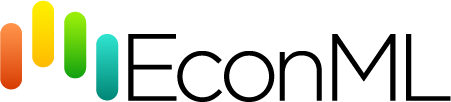

# **KDD2021 Tutorial:** [Causal Inference and Machine Learning in Practice with EconML and CausalML: Industrial Use Cases at Microsoft, TripAdvisor, Uber](https://causal-machine-learning.github.io/kdd2023-workshop/)

# Introduction to [EconML](https://github.com/microsoft/EconML)

A python library for estimation of heterogeneous treatment effects with Machine Learning.

**Presentation:** [Introduction to EconML](https://drive.google.com/file/d/1gt4KNznrYbwdryi9jGcC0-hDCNg7mBNE/view?usp=sharing)

**Github:** https://github.com/microsoft/EconML

**Documentation:** https://econml.azurewebsites.net/

By the Microsoft Research project [ALICE (Automated Learning and Intelligence for Causation and Economics)](https://www.microsoft.com/en-us/research/project/alice/)

In [ ]:
#!pip install econml

In [ ]:
!pip install git+https://github.com/microsoft/EconML.git@mehei/driv#egg=econml

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import warnings
warnings.simplefilter('ignore')

In [ ]:
def gen_data(n, discrete=False):
    X = np.random.normal(0, 1, size=(n, 2))
    W = np.random.normal(0, 1, size=(n, 2))
    if discrete:
        T = np.random.binomial(1, scipy.special.expit(W[:, 0]))
    else:
        T = W[:, 0] + np.random.normal(0, 1, size=(n,))
    y = (X[:, 0] + 1) * T + W[:, 0] + np.random.normal(0, 1, size=(n,))
    return y, T, X, W

def gen_data_iv(n):
    X = np.random.normal(0, 1, size=(n, 2))
    W = np.random.normal(0, 1, size=(n, 2))
    U = np.random.normal(0, 1, size=(n,))
    Z = np.random.normal(0, 1, size=(n,))
    T = Z + W[:, 0] + U
    y = (X[:, 0] + 1) * T + W[:, 0] + U
    return y, T, Z, X, W

# 1. Estimation under Exogeneity

In [ ]:
y, T, X, W = gen_data(1000)

In [ ]:
from econml.dml import NonParamDML

est = NonParamDML(model_y=RandomForestRegressor(), # Any ML model for E[Y|X,W]
                  model_t=RandomForestRegressor(), # Any ML model for E[T|X,W]
                  model_final=RandomForestRegressor(max_depth=2), # Any ML model for CATE
                  discrete_treatment=False, # categorical or continuous treatment
                  cv=2, # number of crossfit folds
                  mc_iters=1) # repetitions of cross-fitting for stability

est.fit(y, T, X=X, W=W, cache_values=True) # fit the CATE model

#### Personalized effect estimates on test samples

In [ ]:
# personalized effect for each sample from going from treatment 0 to treatment level 1
est.effect(X[:5], T0=0, T1=1)

array([ 1.54592291,  0.87946172, -0.47128723,  0.81285758,  3.1442986 ])

#### ML model diagnostics

In [ ]:
# fitted nuisance models for each cross-fitting fold and out-of-sample scores
est.models_y, est.nuisance_scores_y

([[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_state=None, verbose=0, warm_start=False),
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_stat

In [ ]:
est.models_t, est.nuisance_scores_t

([[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_state=None, verbose=0, warm_start=False),
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_stat

#### CATE model diagnostics

In [ ]:
# in-sample goodness-of-fit score for the final cate model
print(est.score_)

1.4717907756757855


#### Nuisance quantity diagnostics

In [ ]:
# calculated residuals for each training sample
yres, Tres, X_cache, W_cache = est.residuals_

# 2. Estimation with Instruments

In [ ]:
y, T, Z, X, W = gen_data_iv(2000)

In [ ]:
from econml.iv.dml import OrthoIV

est = OrthoIV(model_y_xw=RandomForestRegressor(), # ML model for E[Y|X,W]
              model_t_xw=RandomForestRegressor(), # ML model for E[T|X,W]
              model_z_xw=RandomForestRegressor(), # ML model for E[Z|X,W]
              discrete_treatment=False, # categorical/continuous treatment
              discrete_instrument=False, # categorical/continuous instrument
              cv=2, # number of crossfit folds
              mc_iters=1) # repetitions of cross-fitting for stability

In [ ]:
est.fit(y, T, Z=Z, X=X, W=W, cache_values=True)

#### Personalized effect estimates on test samples

In [ ]:
est.effect(X, T0=0, T1=1)

array([-0.32390668,  2.23728003,  0.70346148, ...,  0.85984079,
        0.17539819,  1.07325619])

#### ML model diagnostics

In [ ]:
est.models_y_xw, est.nuisance_scores_y_xw

([[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_state=None, verbose=0, warm_start=False),
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_stat

In [ ]:
est.models_t_xw, est.nuisance_scores_t_xw

([[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_state=None, verbose=0, warm_start=False),
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_stat

In [ ]:
est.models_z_xw, est.nuisance_scores_z_xw

([[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_state=None, verbose=0, warm_start=False),
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=None, oob_score=False,
                         random_stat

#### CATE model diagnostics

In [ ]:
print(est.score_)

5.018208071305707e-16


#### Nuisance quantity diagnostics

In [ ]:
yres, Tres, Zres, Xc, Wc, Zc = est.residuals_

# 3. Inference

In [ ]:
y, T, X, W = gen_data(1000)

### Generic Bootstrap Inference

In [ ]:
from econml.dml import NonParamDML
from econml.sklearn_extensions.linear_model import WeightedLasso

est = NonParamDML(model_y=Lasso(alpha=.1), # Any ML model for E[Y|X,W]
                  model_t=Lasso(alpha=.1), # Any ML model for E[T|X,W]
                  model_final=WeightedLasso(alpha=.1), # Any ML model for CATE that accepts `sample_weight` at fit
                  discrete_treatment=False, # categorical or continuous treatment
                  cv=2, # number of crossfit folds
                  mc_iters=1) # repetitions of cross-fitting for stability

In [ ]:
est.fit(y, T, X=X, W=W, inference='bootstrap') # fit the CATE model

In [ ]:
est.effect_inference(X[:5], T0=0, T1=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.270,0.039,32.620,0.0,1.210,1.334
1,1.707,0.051,33.634,0.0,1.631,1.787
2,2.417,0.079,30.428,0.0,2.304,2.559
3,1.374,0.041,33.700,0.0,1.312,1.445
4,-0.302,0.070,-4.338,0.0,-0.449,-0.216


In [ ]:
est.ate_inference(X)

In [ ]:
from econml.inference import BootstrapInference
est.fit(y, T, X=X, W=W,
        inference=BootstrapInference(n_bootstrap_samples=100,
                                     bootstrap_type='normal'))

In [ ]:
est.effect_inference(X[:5], T0=0, T1=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.267,0.046,27.591,0.0,1.192,1.343
1,1.704,0.055,30.978,0.0,1.613,1.794
2,2.414,0.079,30.623,0.0,2.284,2.543
3,1.372,0.048,28.879,0.0,1.294,1.450
4,-0.303,0.073,-4.125,0.0,-0.424,-0.182


In [ ]:
est.ate_inference(X)

### Tailored Valid Inference

#### Heteroskedasticity-robust OLS inference for linear CATE models $\theta(x)=\langle\theta, \phi(x)\rangle$

In [ ]:
from econml.dml import LinearDML

est = LinearDML(model_y=RandomForestRegressor(), # Any ML model for E[Y|X,W]
                  model_t=RandomForestRegressor(), # Any ML model for E[T|X,W]
                  featurizer=PolynomialFeatures(degree=2, include_bias=False)) # any featurizer for 

In [ ]:
est.fit(y, T, X=X, W=W)

In [ ]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,1.001,0.034,29.398,0.0,0.945,1.057
X1,0.042,0.032,1.302,0.193,-0.011,0.094
X0^2,0.011,0.025,0.447,0.655,-0.029,0.052
X0 X1,0.032,0.027,1.203,0.229,-0.012,0.076
X1^2,-0.024,0.019,-1.269,0.204,-0.056,0.007
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.99,0.046,21.503,0.0,0.914,1.066


In [ ]:
est.effect_inference(X[:5], T0=0, T1=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.261,0.047,26.732,0.0,1.184,1.339
1,1.785,0.068,26.274,0.0,1.673,1.897
2,2.416,0.083,29.069,0.0,2.280,2.553
3,1.418,0.048,29.828,0.0,1.340,1.497
4,-0.272,0.064,-4.266,0.0,-0.378,-0.167


#### Debiased Lasso Inference for high-dimensional linear CATE models $\theta(x)=\langle\theta, \phi(x)\rangle$

In [ ]:
from econml.dml import SparseLinearDML

est = SparseLinearDML(featurizer=PolynomialFeatures(degree=3, include_bias=False))

In [ ]:
est.fit(y, T, X=X, W=W)

In [ ]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.99,0.065,15.182,0.0,0.882,1.097
X1,0.012,0.07,0.179,0.858,-0.102,0.127
X0^2,0.071,0.022,3.168,0.002,0.034,0.107
X0 X1,-0.012,0.034,-0.337,0.736,-0.068,0.045
X1^2,-0.019,0.027,-0.686,0.493,-0.063,0.026
X0^3,0.004,0.013,0.328,0.743,-0.017,0.026
X0^2 X1,0.026,0.025,1.025,0.305,-0.016,0.067
X0 X1^2,0.021,0.026,0.806,0.42,-0.022,0.065
X1^3,0.001,0.016,0.054,0.957,-0.026,0.027
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper


In [ ]:
est.effect_inference(X[:5], T0=0, T1=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.244,0.061,20.458,0.000,1.144,1.344
1,1.743,0.102,17.120,0.000,1.575,1.910
2,2.528,0.092,27.553,0.000,2.377,2.679
3,1.366,0.061,22.521,0.000,1.266,1.466
4,-0.236,0.085,-2.778,0.005,-0.376,-0.096


#### Bootstrap-of-Little-Bags inference for forests CATE models $\theta(x)$

In [ ]:
y, T, X, W = gen_data(2000, discrete=True)

In [ ]:
from econml.dml import CausalForestDML

est = CausalForestDML(discrete_treatment=True,
                      criterion='mse', n_estimators=1000)
est.tune(y, T, X=X, W=W)
est.fit(y, T, X=X, W=W, cache_values=True)

In [ ]:
est.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate              
===============================================================
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     1.099       0.205 5.362    0.0         0.762         1.436
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    1.086          -0.862           2.947
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       1.105         -0.862          2.965
        Doubly Robust ATE on Training Data Results       
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE          1.095  0.056 19.388    0.0    1.002    1.187
     Doubly Robust ATT(T=0) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          1.075  0.078 13.719    0.0    0.947    1.204
     Doubly Robust ATT(T=1) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          1.116  0.081 13.721    0.0    0.982     1.25
---------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

In [ ]:
est.effect_inference(X[:5], T0=0, T1=1).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.909,0.230,8.293,0.000,1.531,2.288
1,0.308,0.113,2.735,0.006,0.123,0.493
2,-0.113,0.204,-0.553,0.580,-0.449,0.223
3,1.277,0.192,6.665,0.000,0.962,1.593
4,2.395,0.225,10.639,0.000,2.024,2.765


# 4. Causal Scoring

In [ ]:
y, T, X, W = gen_data(2000, discrete=True)

#### Multitude of approaches for CATE estimation to select from

In [ ]:
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML
from econml.metalearners import XLearner, TLearner, SLearner, DomainAdaptationLearner
from econml.dr import DRLearner

reg = lambda: RandomForestRegressor(min_samples_leaf=10)
clf = lambda: RandomForestClassifier(min_samples_leaf=10)
# A multitude of possible approaches for CATE estimation under conditional exogeneity
models = [('ldml', LinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                             linear_first_stages=False, cv=3)),
          ('sldml', SparseLinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                                    featurizer=PolynomialFeatures(degree=2, include_bias=False),
                                    linear_first_stages=False, cv=3)),
          ('xlearner', XLearner(models=reg(), cate_models=reg(), propensity_model=clf())),
          ('dalearner', DomainAdaptationLearner(models=reg(), final_models=reg(),
                                                propensity_model=clf())),
          ('slearner', SLearner(overall_model=reg())),
          ('tlearner', TLearner(models=reg())),
          ('drlearner', DRLearner(model_propensity=clf(), model_regression=reg(),
                                  model_final=reg(), cv=3)),
          ('rlearner', NonParamDML(model_y=reg(), model_t=clf(), model_final=reg(),
                                   discrete_treatment=True, cv=3)),
          ('dml3dlasso', DML(model_y=reg(), model_t=clf(), model_final=LassoCV(),
                             discrete_treatment=True,
                             featurizer=PolynomialFeatures(degree=3),
                             linear_first_stages=False, cv=3))
]

#### Split the data in train and validation

In [ ]:
XW = np.hstack([X, W])
XW_train, XW_val, T_train, T_val, Y_train, Y_val = train_test_split(XW, T, y, test_size=.4)

#### Fit all CATE models on train data

In [ ]:
from joblib import Parallel, delayed

def fit_model(name, model):
    return name, model.fit(Y_train, T_train, X=XW_train)

models = Parallel(n_jobs=-1, verbose=1)(delayed(fit_model)(name, mdl) for name, mdl in models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   17.7s finished


#### Train the scorer on the validation data

In [ ]:
from econml.score import RScorer

# Causal score actually needs fitting on the test set!
scorer = RScorer(model_y=reg(), model_t=clf(),
                 discrete_treatment=True, cv=3,
                 mc_iters=3, mc_agg='median')
scorer.fit(Y_val, T_val, X=XW_val)

#### Evaluate each of the trained CATE models on the validation data

In [ ]:
# Then we can evaluate every trained CATE model
rscore = [scorer.score(mdl) for _, mdl in models]

#### Calculate ideal score of each model, since we know ground truth

In [ ]:
expected_te_val = 1 + XW_val[:, 0]

In [ ]:
rootpehe = [np.sqrt(np.mean((expected_te_val.flatten() - mdl.effect(XW_val).flatten())**2))
            for _, mdl in models]

#### Qualitatively different performance of each method

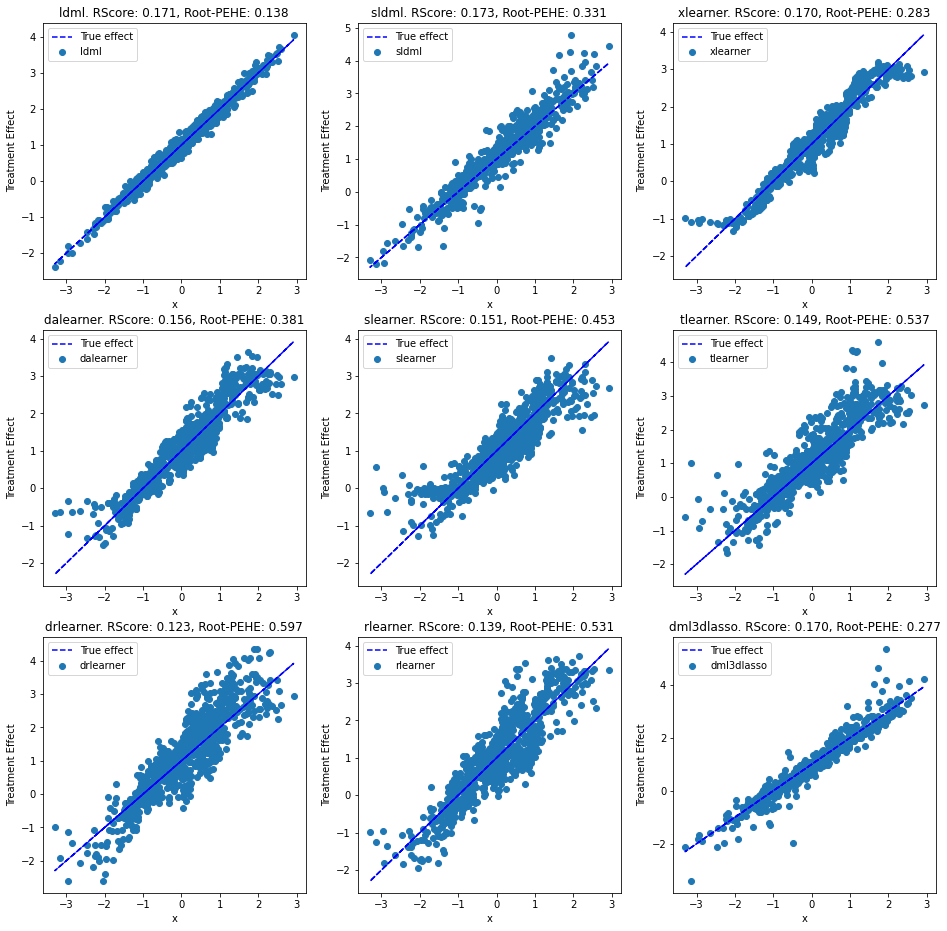

In [ ]:
plt.figure(figsize=(16, 16))
rows = int(np.ceil(len(models) / 3))
for it, (name, mdl) in enumerate(models):
    plt.subplot(rows, 3, it + 1)
    plt.title('{}. RScore: {:.3f}, Root-PEHE: {:.3f}'.format(name, rscore[it], rootpehe[it]))
    plt.scatter(XW_val[:, 0], mdl.effect(XW_val), label='{}'.format(name))
    plt.plot(XW_val[:, 0], 1 + XW_val[:, 0], 'b--', label='True effect')
    plt.ylabel('Treatment Effect')
    plt.xlabel('x')
    plt.legend()
plt.show()

#### RScore correlates well with ideal score

Higher `Rscore` implies smaller `PEHE`

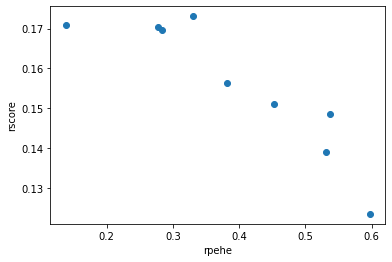

In [ ]:
plt.scatter(rootpehe, rscore)
plt.xlabel('rpehe')
plt.ylabel('rscore')
plt.show()

#### Choose CATE model with larger Rscore

In [ ]:
mdl, score  = scorer.best_model([mdl for _, mdl in models])
mdl

In [ ]:
rootpehe_best = np.sqrt(np.mean((expected_te_val.flatten() - mdl.effect(XW_val).flatten())**2))

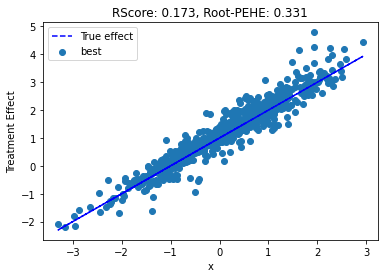

In [ ]:
plt.figure()
plt.title('RScore: {:.3f}, Root-PEHE: {:.3f}'.format(score, rootpehe_best))
plt.scatter(XW_val[:, 0], mdl.effect(XW_val), label='best')
plt.plot(XW_val[:, 0], 1 + XW_val[:, 0], 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

# 4. Interpretation

In [ ]:
y, T, X, W = gen_data(2000, discrete=True)

#### Fit any CATE model

In [ ]:
from econml.dml import NonParamDML

est = NonParamDML(model_y=RandomForestRegressor(min_samples_leaf=10), # Any ML model for E[Y|X,W]
                  model_t=RandomForestClassifier(min_samples_leaf=10), # Any ML model for E[T|X,W]
                  model_final=RandomForestRegressor(max_depth=2), # Any ML model for CATE
                  discrete_treatment=True, # categorical or continuous treatment
                  cv=5, # number of crossfit folds
                  mc_iters=1) # repetitions of cross-fitting for stability

est.fit(y, T, X=X, W=W, cache_values=True) # fit the CATE model

#### Interpret its behavior with a single Tree

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(max_depth=1)
intrp.interpret(est, X)

In [ ]:
intrp.export_graphviz(out_file='cate_tree.dot')

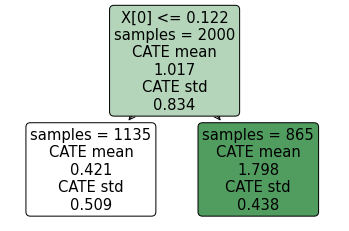

In [ ]:
intrp.plot()

#### Make tree-based policy recommendations from CATE model

In [ ]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

intrp = SingleTreePolicyInterpreter(max_depth=1)
intrp.interpret(est, X, sample_treatment_costs=0.2)

In [ ]:
intrp.export_graphviz(out_file='policy_tree.dot')

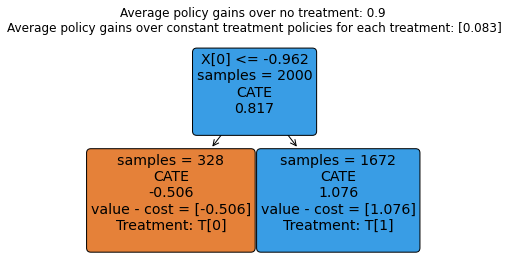

In [ ]:
intrp.plot()

#### Interpret CATE model with SHAP

In [ ]:
shap_values = est.shap_values(X)

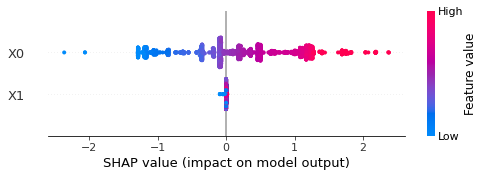

In [ ]:
import shap

# effect heterogeneity feature importances with summary plot
shap.summary_plot(shap_values['Y0']['T0_1'])

In [ ]:
shap.initjs()
# explain the heterogeneity of the effect of any single sample
shap.force_plot(shap_values['Y0']['T0_1'][0])

# 5. Validation and Sensitivity

In [ ]:
y, T, Z, X, W = gen_data_iv(2000)

#### Instantiate any CATE model

In [ ]:
from econml.iv.dml import OrthoIV

est = OrthoIV(model_y_xw=RandomForestRegressor(), # ML model for E[Y|X,W]
              model_t_xw=RandomForestRegressor(), # ML model for E[Y|X,W]
              model_z_xw=RandomForestRegressor(), # ML model for E[Y|X,W]
              discrete_treatment=False, # categorical/continuous treatment
              discrete_instrument=False, # categorical/continuous instrument
              cv=2, # number of crossfit folds
              mc_iters=1) # repetitions of cross-fitting for stability

#### Enable dowhy capabilities

In [ ]:
import dowhy
est = est.dowhy

#### Then fit

In [ ]:
est.fit(y, T, Z=Z, X=X, W=W, cache_values=True)

#### Use it as a normal EconML cate estimator

In [ ]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.99,0.035,27.933,0.0,0.932,1.049
X1,-0.012,0.027,-0.441,0.659,-0.057,0.033
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1.018,0.026,38.577,0.0,0.975,1.061


In [ ]:
est.effect_inference(X[:5]).summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.286,0.045,6.362,0.0,0.212,0.360
1,2.730,0.071,38.618,0.0,2.613,2.846
2,0.678,0.030,22.866,0.0,0.630,0.727
3,0.760,0.038,19.951,0.0,0.697,0.823
4,2.539,0.086,29.605,0.0,2.398,2.680


#### But now we also have DoWhy capabilities: Sensitivity Analysis

In [ ]:
ref_res = est.refute_estimate(method_name="add_unobserved_common_cause",
                              effect_strenght_on_treatment=0.05,
                              effect_strength_on_outcome=0.5)

In [ ]:
print(ref_res)

Refute: Add an Unobserved Common Cause
Estimated effect:1.0314669223854354
New effect:0.9983858330683743



# 6. Policy Learning

In [ ]:
y, T, X, W = gen_data(2000, discrete=True)

#### Fit a Doubly Robust policy tree

In [ ]:
from econml.policy import DRPolicyTree

est = DRPolicyTree(max_depth=2, min_impurity_decrease=0.01, honest=True)

In [ ]:
est.fit(y, T, X=X, W=W)

#### Visualize treatment policy

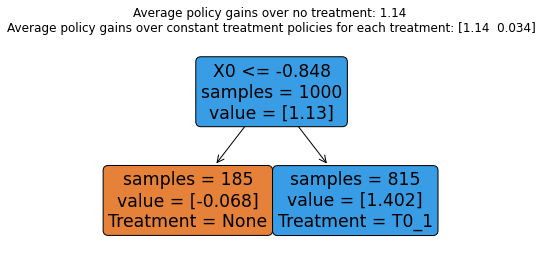

In [ ]:
est.plot()

In [ ]:
est.feature_importances_

array([1., 0.])

#### Produce recommended treatments

In [ ]:
est.predict(X[:100])

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

#### Fit a Doubly Robust policy forest

In [ ]:
from econml.policy import DRPolicyForest

est = DRPolicyForest(n_estimators=100, max_depth=2,
                     min_impurity_decrease=0.01, honest=True)

In [ ]:
est.fit(y, T, X=X, W=W)

#### Produce recommended treatments

In [ ]:
est.predict(X[:100])

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Plot one of the trees

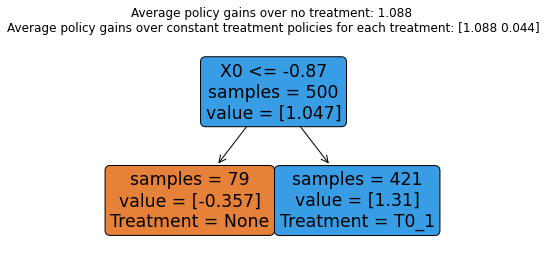

In [ ]:
est.plot(0)

#### Plot decisions as function of covariates

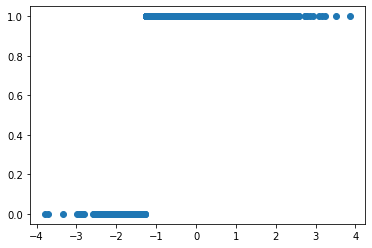

In [ ]:
plt.scatter(X[:, 0], est.predict(X))
plt.show()